# Introduction to CNN's with Tensorflow

## Download our DataSet - Food 101

In [1]:
import zipfile

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2021-11-30 18:58:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 64.233.181.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.50M  37.0MB/s    in 2.8s    

2021-11-30 18:58:13 (37.0 MB/s) - ‘pizza_steak.zip.1’ saved [109579078/109579078]



In [3]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip')

In [4]:
zip_ref.extractall()
zip_ref.close()

### Inspect the data - become one with the data

In [5]:
!ls pizza_steak

test  train


In [6]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

In [7]:
random.seed(711)

In [8]:
# walk through the pizza steak directory and list files
# the strange images are because of the hidden files in the directories
for dirpath, dirname, filename in os.walk('pizza_steak'):
  print(f'there are {len(dirname)} directories and {len(filename)} images in {dirpath}.')

there are 2 directories and 1 images in pizza_steak.
there are 2 directories and 1 images in pizza_steak/train.
there are 0 directories and 750 images in pizza_steak/train/steak.
there are 0 directories and 750 images in pizza_steak/train/pizza.
there are 2 directories and 1 images in pizza_steak/test.
there are 0 directories and 250 images in pizza_steak/test/steak.
there are 0 directories and 250 images in pizza_steak/test/pizza.


In [9]:
# check the hidden files in the directory
!ls -la pizza_steak

total 24
drwxr-xr-x 4 root root 4096 Nov 30 18:57 .
drwxr-xr-x 1 root root 4096 Nov 30 18:58 ..
-rw-r--r-- 1 root root 6148 Nov 30 18:58 .DS_Store
drwxr-xr-x 4 root root 4096 Nov 30 18:57 test
drwxr-xr-x 4 root root 4096 Nov 30 18:57 train


In [10]:
def plot_images_of_class(show_images=False, rand = True, dirname='pizza_steak', class_='pizza', files='train', num_pics = 10):
   shapes = []
   #change to the desired directory
   os.chdir('/content/'+dirname+'/'+files+'/'+class_)
   # get the images in the dir
   images = os.listdir()
   # check if we have to plot all images
   try:
     int(num_pics)
   except:
     num_pics = len(images) 
   for i in range(num_pics):
     # random.sample would also be possible
     image_path = images[random.randint(0,len(images)-1)] if rand else images[i]
     image = mpimg.imread(image_path)
     shape = image.shape
     shapes.append(shape)
     if show_images:
       plt.imshow(image)
       print('shape', shape)
     plt.show()
   df =pd.DataFrame({'x_pixels':[s[0] for s in shapes],
              'y_pixels':[s[1] for s in shapes],
              'col_channels':[s[2] for s in shapes]
              })
   return df

In [11]:
df_shapes = plot_images_of_class(rand=False, num_pics='all')

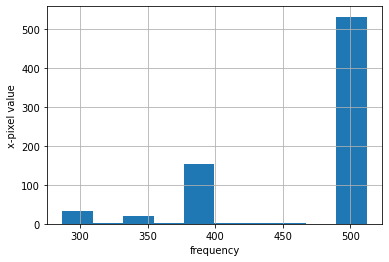

In [12]:
# plot the distribution of the x-pixel values
df_shapes.x_pixels.hist()
plt.xlabel('frequency')
plt.ylabel('x-pixel value')
plt.show()

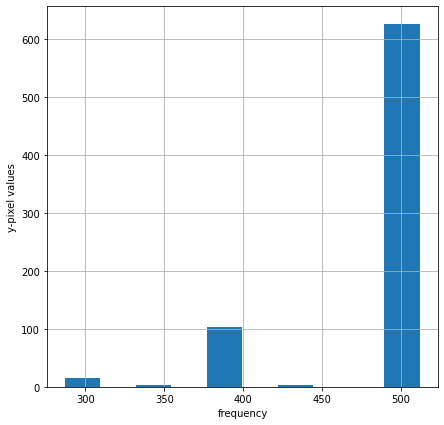

In [13]:
# plot the distribution of the y-pixel values
df_shapes.y_pixels.hist(figsize=(7,7))
plt.xlabel('frequency')
plt.ylabel('y-pixel values')
plt.show()

In [14]:
df_shapes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   x_pixels      750 non-null    int64
 1   y_pixels      750 non-null    int64
 2   col_channels  750 non-null    int64
dtypes: int64(3)
memory usage: 17.7 KB


In [15]:
df_shapes['combined_pixel_shapes']= df_shapes.x_pixels.astype('str') + ',' + df_shapes.y_pixels.astype('str')

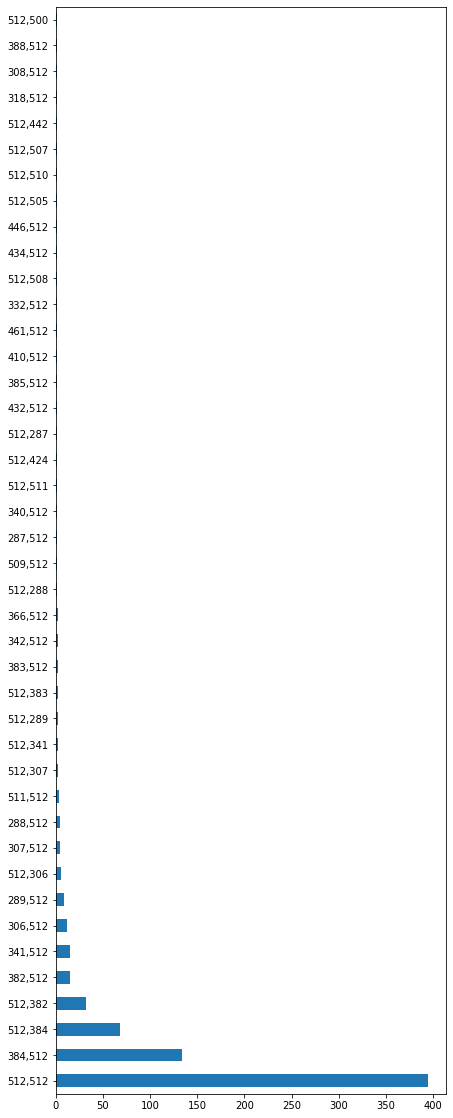

In [16]:
df_shapes['combined_pixel_shapes'].value_counts().plot(kind='barh',figsize=(7,20))
plt.show()

### Build a first model

In [17]:
# IMPORTS
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# preprocessing data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# setup paths
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

# import the data from dirs and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size = (224,224),
                                               class_mode='binary',
                                               seed=711)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size = (224,224),
                                               class_mode='binary',
                                               seed=711)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [19]:
# 1. Build the CNN
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.Conv2D(10,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# 2. Compile the CNN
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

In [20]:
# check how many batches we have
len(train_data) # 1500 images // 32 (batchsize)

47

In [21]:
# check what GPU we are using if any -> if not, switch to gpu
!nvidia-smi

Tue Nov 30 18:58:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    73W / 149W |    147MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# 3. Build the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 22s 273ms/step - loss: 0.5471 - accuracy: 0.7147 - val_loss: 0.3900 - val_accuracy: 0.8400
Epoch 2/5
47/47 [==============================] - 12s 247ms/step - loss: 0.4239 - accuracy: 0.8060 - val_loss: 0.3598 - val_accuracy: 0.8520
Epoch 3/5
47/47 [==============================] - 12s 245ms/step - loss: 0.3813 - accuracy: 0.8360 - val_loss: 0.3319 - val_accuracy: 0.8720
Epoch 4/5
47/47 [==============================] - 12s 246ms/step - loss: 0.3655 - accuracy: 0.8340 - val_loss: 0.3390 - val_accuracy: 0.8740
Epoch 5/5
47/47 [==============================] - 12s 245ms/step - loss: 0.3229 - accuracy: 0.8693 - val_loss: 0.3588 - val_accuracy: 0.8420


In [23]:
# get model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

### Build a simple NN and compare the results to our CNN

In [24]:
# 1. Build the model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224,224,3)),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(1)
])
# 2. Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics='accuracy')

In [25]:
# 3. Build the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 11s 217ms/step - loss: 3.3721 - accuracy: 0.5807 - val_loss: 1.3591 - val_accuracy: 0.6500
Epoch 2/5
47/47 [==============================] - 10s 211ms/step - loss: 0.7700 - accuracy: 0.7067 - val_loss: 1.6348 - val_accuracy: 0.5180
Epoch 3/5
47/47 [==============================] - 10s 210ms/step - loss: 0.6615 - accuracy: 0.7533 - val_loss: 0.4767 - val_accuracy: 0.7460
Epoch 4/5
47/47 [==============================] - 10s 206ms/step - loss: 0.5446 - accuracy: 0.7680 - val_loss: 1.0808 - val_accuracy: 0.5780
Epoch 5/5
47/47 [==============================] - 10s 205ms/step - loss: 0.5945 - accuracy: 0.7420 - val_loss: 0.5364 - val_accuracy: 0.7200


In [26]:
# get a summary of the model_2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 100)               15052900  
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


### Build a simple baseline CNN model

In [27]:
# 1. Build the model
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Conv2D(10,3,activation='relu',input_shape=(224,224,3)))
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(1))

# 2. Compile the model
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics='accuracy')

In [28]:
# 3. Fit the model
history_3 = model_3.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
47/47 [==============================] - 11s 223ms/step - loss: 2.7164 - accuracy: 0.6893 - val_loss: 0.4818 - val_accuracy: 0.7580
Epoch 2/5
47/47 [==============================] - 10s 210ms/step - loss: 0.4354 - accuracy: 0.7967 - val_loss: 0.4125 - val_accuracy: 0.8060
Epoch 3/5
47/47 [==============================] - 10s 216ms/step - loss: 0.2398 - accuracy: 0.9080 - val_loss: 0.3999 - val_accuracy: 0.8320
Epoch 4/5
47/47 [==============================] - 10s 215ms/step - loss: 0.1320 - accuracy: 0.9607 - val_loss: 0.5478 - val_accuracy: 0.7840
Epoch 5/5
47/47 [==============================] - 10s 212ms/step - loss: 0.0832 - accuracy: 0.9813 - val_loss: 0.4478 - val_accuracy: 0.8440


In [29]:
# 4. Evaluate the model
model_3.evaluate(valid_data)

16/16 [==============================] - 2s 149ms/step - loss: 0.4478 - accuracy: 0.8440


[0.447780579328537, 0.843999981880188]

In [30]:
# print a summary
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 flatten_2 (Flatten)         (None, 492840)            0         
                                                                 
 dense_5 (Dense)             (None, 1)                 492841    
                                                                 
Total params: 493,121
Trainable params: 493,121
Non-trainable params: 0
_________________________________________________________________


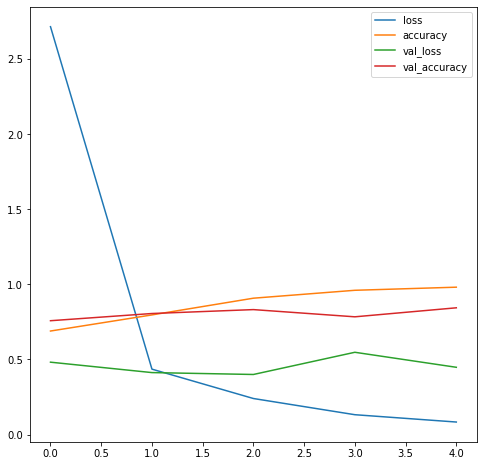

In [31]:
# visualize the training process
import pandas as pd
pd.DataFrame(history_3.history).plot(figsize=(8,8))
plt.show()

### Try a regularized model

In [32]:
# 1. Build the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics='accuracy')

In [33]:
# 3. Fit the model
history_4 = model_4.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
47/47 [==============================] - 11s 226ms/step - loss: 0.5766 - accuracy: 0.6580 - val_loss: 0.4436 - val_accuracy: 0.7760
Epoch 2/5
47/47 [==============================] - 10s 221ms/step - loss: 0.4640 - accuracy: 0.7733 - val_loss: 0.4642 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 10s 220ms/step - loss: 0.4582 - accuracy: 0.7873 - val_loss: 0.3678 - val_accuracy: 0.8300
Epoch 4/5
47/47 [==============================] - 10s 216ms/step - loss: 0.4182 - accuracy: 0.8113 - val_loss: 0.3537 - val_accuracy: 0.8500
Epoch 5/5
47/47 [==============================] - 10s 220ms/step - loss: 0.3865 - accuracy: 0.8227 - val_loss: 0.3771 - val_accuracy: 0.7800


In [34]:
# 4. Evaluate the model
model_4.evaluate(valid_data)

16/16 [==============================] - 3s 155ms/step - loss: 0.3771 - accuracy: 0.7800


[0.3771247863769531, 0.7799999713897705]

In [35]:
# get a summary
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

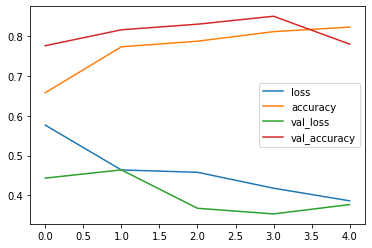

In [36]:
pd.DataFrame(history_4.history).plot()
plt.show()

### Data Augmentation to reduce overfitting

In [37]:
# create a training set of data with data augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.3,
    horizontal_flip=True
)

# create training data without data augemntation
train_datagen = ImageDataGenerator(rescale=1./255)

# create test data without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
# setup paths
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

# import the data from dirs and turn it into batches
train_data_augmented = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size = (224,224),
                                               class_mode='binary',
                                               shuffle=True,
                                               seed=711)

# import the data from dirs and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size = (224,224),
                                               class_mode='binary',
                                               shuffle=True,
                                               seed=711)

test_datagen = test_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size = (224,224),
                                               class_mode='binary',
                                               shuffle=True,
                                               seed=711)

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [39]:
# get sample data batches
images, labels = train_data.next()
images_augmented, labels_augmented = train_data_augmented.next()

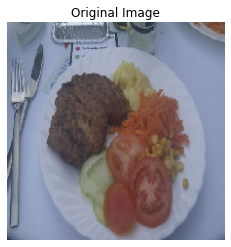

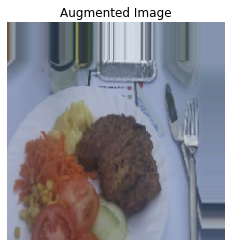

In [40]:
# show original and augmented data
import random
random_number = random.randint(0,32)
plt.figure()
plt.imshow(images[random_number])
plt.title('Original Image')
plt.axis(False)
plt.show()
plt.figure()
plt.imshow(images_augmented[random_number])
plt.title('Augmented Image')
plt.axis(False)
plt.show()

### Create a model that is trained on augmented data

In [41]:
# 1. Build the model
model_5 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics='accuracy')

In [42]:
model_5.fit(train_data_augmented,epochs=5)

Epoch 1/5
47/47 [==============================] - 23s 483ms/step - loss: 0.6456 - accuracy: 0.5553
Epoch 2/5
47/47 [==============================] - 23s 482ms/step - loss: 0.5474 - accuracy: 0.7213
Epoch 3/5
47/47 [==============================] - 23s 488ms/step - loss: 0.5603 - accuracy: 0.7007
Epoch 4/5
47/47 [==============================] - 23s 481ms/step - loss: 0.5123 - accuracy: 0.7413
Epoch 5/5
47/47 [==============================] - 22s 475ms/step - loss: 0.4873 - accuracy: 0.7573


## Create a final even better model

In [43]:
import tensorflow as tf

In [44]:
# 1. Build the model
model_6 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1,activation='sigmoid')
])

# 2. Compile the model
model_6.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics='accuracy'
)

In [45]:
# 3. Fit the model
model_6.fit(train_data_augmented,epochs=5)

Epoch 1/5
47/47 [==============================] - 24s 501ms/step - loss: 0.6587 - accuracy: 0.6060
Epoch 2/5
47/47 [==============================] - 24s 507ms/step - loss: 0.5660 - accuracy: 0.7147
Epoch 3/5
47/47 [==============================] - 24s 519ms/step - loss: 0.5264 - accuracy: 0.7380
Epoch 4/5
47/47 [==============================] - 25s 522ms/step - loss: 0.5162 - accuracy: 0.7613
Epoch 5/5
47/47 [==============================] - 24s 512ms/step - loss: 0.4656 - accuracy: 0.7813


## Multi-Class Image classification

**10 classes of food**

### 1. Become one with the data

In [46]:
# IMPORTS

# 1. Become one with the data
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import matplotlib.image as mpimg

# 2. Preprocessing image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 6. Hyperparameter tuning
from tensorflow.keras.callbacks import LearningRateScheduler

In [47]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip","r")
zip_ref.extractall()
zip_ref.close()

--2021-11-30 19:06:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   120MB/s    in 4.2s    

2021-11-30 19:06:16 (117 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [48]:
os.chdir('/content/10_food_classes_all_data')

FileNotFoundError: ignored

In [ ]:
# walk through the classes of food and check the number of samples in training and testsets
for dirpath, dirname, filename in os.walk('10_food_classes_all_data'):
  print(f'there are {len(dirname)} directories and {len(filename)} images in {dirpath}.')

In [ ]:
def plot_images_of_class(show_images=False, rand = True, dirname='pizza_steak', class_=None, files='train', num_pics = 10):
   shapes = []
   if class_ == None:
     os.chdir('/content/'+dirname+'/'+files+'/')
     class_ = random.choice(os.listdir())
   #change to the desired directory
   os.chdir('/content/'+dirname+'/'+files+'/'+class_)
   # check if we have to plot all images
   try:
     int(num_pics)
   except:
     num_pics = len(os.listdir()) 
   for path in random.sample(os.listdir(),num_pics):
     # random.sample would also be possible
     image = mpimg.imread(path)
     shape = image.shape
     shapes.append(shape)
     if show_images:
       plt.imshow(image)
       plt.title(class_)
       plt.axis(False)
       plt.show()
     else: 
       df =pd.DataFrame({'x_pixels':[s[0] for s in shapes],
                  'y_pixels':[s[1] for s in shapes],
                  'col_channels':[s[2] for s in shapes]
                  })
       return df

In [ ]:
plot_images_of_class(show_images=True,dirname='10_food_classes_all_data')

### 2. Preprocessing of the data (prepare it for a model)

In [ ]:
# rescale data to [0,1]
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# set train and test directory
train_dir = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [ ]:
# reset the path
os.chdir('/content')

# prepare the data batches
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32
)

### 3. Create a CNN baseline model

In [ ]:
# 1. Build the model
model_base = tf.keras.Sequential([
  tf.keras.layers.Conv2D(10,3,activation='relu',input_shape=(224,224,3)),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.Conv2D(10,3,activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

In [ ]:
# 2. Compile the model
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### 4. Fit the model

In [ ]:
# 3. Fit the model
history_base = model_base.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data,validation_steps=len(test_data))

### 5. Evaluate the model

In [ ]:
# 4. Evaluate the model
model_base.evaluate(test_data)

In [ ]:
# plot loss and training curves
def plot_acc_and_loss(history, lrs = False, epochs = 5):
  df = pd.DataFrame(history.history)
  df[[col for col in df.columns if 'acc' in col]].plot(figsize=(8,8))
  plt.title('Training and Validation Accuracy while Training')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()
  df[[col for col in df.columns if 'loss' in col]].plot(figsize=(8,8))
  plt.title('Loss and Validation Loss while Training')
  plt.xlabel('epochs')
  plt.legend()
  plt.show()
  if lrs: 
    lr = lambda epoch: 1e-3 * 10**(epoch/(epochs/2))
    learning_rates = lr(np.arange(1,epochs+1))
    plt.semilogx(
        learning_rates, 
        history.history['loss'], 
        lw=3, color='#000'
    )
    plt.title('Learning rate vs. loss', size=20)
    plt.xlabel('Learning rate', size=14)
    plt.ylabel('Loss', size=14);

In [ ]:
plot_acc_and_loss(history_base)

In [ ]:
model_base.summary()

### 6. Hyperparameter tuning (reduce overfitting to beat the baseline model)

#### Create augmented data

In [ ]:
# create a training set of data with data augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.3,
    horizontal_flip=True
)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)

In [ ]:
# clone the baseline model and train it with augmented data
model_i1 = tf.keras.models.clone_model(model_base)

In [ ]:
# 2. Compile the model
model_i1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# 3. Fit the model
history_i1 = model_i1.fit(train_data_augmented,epochs=5,steps_per_epoch=len(train_data_augmented),validation_data=test_data,validation_steps=len(test_data))

In [ ]:
model_base.evaluate(test_data)

In [ ]:
model_i1.evaluate(test_data)

In [ ]:
plot_acc_and_loss(history_i1)

#### Train for larger epochs

In [ ]:
# clone the baseline model and train it with augmented data
model_i2 = tf.keras.models.clone_model(model_base)

In [ ]:
# 2. Compile the model
model_i2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# 3. Fit the model
history_i2 = model_i2.fit(train_data_augmented,epochs=15,steps_per_epoch=len(train_data_augmented),validation_data=test_data,validation_steps=len(test_data))

In [ ]:
model_i2.evaluate(test_data)

In [ ]:
plot_acc_and_loss(history_i2)

In [ ]:
model_i2.summary()

### 7. Repeat until satisfied

#### More ways to improve model performace
1. Train model for longer
2. Increase layers and filters
2. Tune learning Rate
3. Use Transfer Learning
4. More data
5. Try more and different data augementation techniques